# 2.0 Exploratory Data Analysis

Contents

2.1 [Introduction](#2.1)

  * [2.1.1 Problem Recap](#2.1.1)
  * [2.1.2 Notebook Goals](#2.1.2)

2.2 [Load data](#2.2)

   * [2.2.1 Imports](#2.2.1)
   * [2.2.2 Load Fashion Dataset](#2.2.2)
    
2.3 [Explore the data](#2.3)
    
   * [2.3.1 Missing Values](#2.3.1)
   * [2.3.2 Examining Star Counts](#2.3.2)
   * [2.3.3 Creating Target Feature](#2.3.3)
   * [2.3.4 Fix Contractions](#2.3.4)
   * [2.3.5 Examine Review Lengths](#2.3.5)

2.4 [Text Cleaning](#2.4)

   * [2.4.1 Removing Numbers and Punctuation](#2.4.1)
   * [2.4.2 Removing Stop Words](#2.4.2)

2.5 [Save the data](#2.5)

2.6 [Conclusions](#2.6)

   * [2.6.1 Summary](#2.6.1)
   * [2.6.2 Next Steps](#2.6.2)

## 2.1 Introduction <a name="2.1"></a>

### 2.1.1 Problem Recap <a name="2.1.1"></a>

Using customer text data about amazon products to build, evaluate and compare models to estimate the probability that a given text review can be classified as “positive” or “negative”.

The project goal is to build a text classifier using Amazon product review data which can be used to analyze customer sentiment which does not have accompanying numeric data.

### 2.1.2 Notebook Goals<a name = "2.1.2"></a>

In this notebook, we will be doing EDA (exploratory data analysis) to examine the shape of our data, its features, missing values, distributions, and any other relevant information.

1. Look for any mistakes with our data collection and data wrangling.

2. Look at relationships between the different features.

3. Look at our target feature.

4. Clean our data of non-letter characters.

## 2.2 Load the Data <a name="2.2"></a>

### 2.2.1 Imports <a name="2.2.1"></a>

In [3]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
from math import log, e
from wordcloud import WordCloud
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import plotly.express as px
from nltk.stem import WordNetLemmatizer

### 2.2.2 Load Fashion Data <a name="2.2.2"></a>

In [4]:
df = pq.read_table("../data/edited/fashion.parquet")
fashion = df.to_pandas()
fashion.head()

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime
0,5,True,A1D4G1SNUZWQOT,7106116521,Exactly what I needed.,perfect replacements!!,1413763200
1,2,True,A3DDWDH9PX2YX2,7106116521,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400
2,4,False,A2MWC41EW7XL15,7106116521,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800
3,2,True,A2UH2QQ275NV45,7106116521,too tiny an opening,Two Stars,1408838400
4,3,False,A89F3LQADZBS5,7106116521,Okay,Three Stars,1406419200


## 2.3 Explore the Data <a name="2.3"></a>

### 2.3.1 Missing Values <a name="2.3.1"><a/>

We don't have many missing values for reviews so we will drop them.

In [5]:
rows_before, _ = fashion.shape

print(f"Rows before removing NA values: {rows_before}")

fashion.dropna(inplace=True)

rows_after, _ = fashion.shape

print(f"Rows after removing NA values {rows_after}")

nans_removed = rows_before - rows_after

print(f"\nTotal Rows removed = {nans_removed}")

Rows before removing NA values: 883636
Rows after removing NA values 881900

Total Rows removed = 1736


Looking at our target column

In [6]:
fashion["overall"].info()

<class 'pandas.core.series.Series'>
Int64Index: 881900 entries, 0 to 883635
Series name: overall
Non-Null Count   Dtype
--------------   -----
881900 non-null  int64
dtypes: int64(1)
memory usage: 13.5 MB


In [7]:
fashion["overall"].describe()

count    881900.000000
mean          3.906144
std           1.418443
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

Converting the text to all lowercase will make it easier to work with.

In [8]:
fashion["reviewText"] = fashion.reviewText.str.lower()

### 2.3.2 Examining Star Counts <a name="2.3.2"><a/>

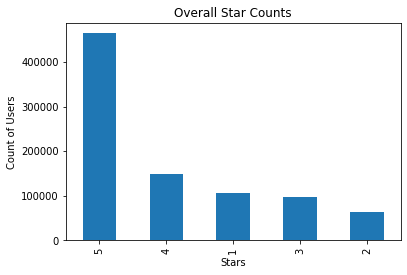

In [9]:
fashion["overall"].value_counts().plot.bar()
plt.title("Overall Star Counts")
plt.xlabel("Stars")
plt.ylabel("Count of Users")
plt.show();

Our dataset is largely positive reviews. Even combining the 1-3 as negative and the 4-5 as positive, we'll still have a bit of imbalance that we'll need to be aware of.

In [10]:
fashion.shape

(881900, 7)

In [11]:
fashion.drop_duplicates(subset=["overall", "reviewText", "asin", "reviewerID"], inplace=True)
fashion.shape

(874374, 7)

In [12]:
stars = ["One Star", "Two Stars", "Three Stars", "Four Stars", "Five Stars"]

nums = [1,2,3,4,5]

A number of review summaries are explicitly "X stars". Let's take a look at the actual score given for them

In [13]:
for s,n in zip(stars, nums):
    partial_df = fashion[fashion["summary"]==s]
    print(f"Number of '{s}' review summaries:", len(partial_df), "\n")
    
    print("Segmented by")
    print(partial_df.groupby("overall")["overall"].count())

Number of 'One Star' review summaries: 34367 

Segmented by
overall
1    34275
2       13
3       23
4       22
5       34
Name: overall, dtype: int64
Number of 'Two Stars' review summaries: 19822 

Segmented by
overall
1       52
2    19702
3       22
4       21
5       25
Name: overall, dtype: int64
Number of 'Three Stars' review summaries: 29908 

Segmented by
overall
1       21
2       22
3    29781
4       41
5       43
Name: overall, dtype: int64
Number of 'Four Stars' review summaries: 45716 

Segmented by
overall
1       18
2       24
3       28
4    45536
5      110
Name: overall, dtype: int64
Number of 'Five Stars' review summaries: 173896 

Segmented by
overall
1        43
2        13
3        39
4        54
5    173747
Name: overall, dtype: int64


Look at word counts and visualize them for the review text by star count. The word cloud library automatically removes stop words for us to give us more meaningful visualizations. We'll have to do this manually later to clean the data.

1.00 Small
0.80 Size
0.78 Fit
0.59 Look
0.50 Way
0.46 Picture
0.45 Cheap


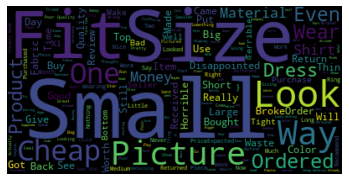

1.00 Small
0.96 Fit
0.84 Size
0.67 Look
0.54 Wear
0.53 Way
0.51 One


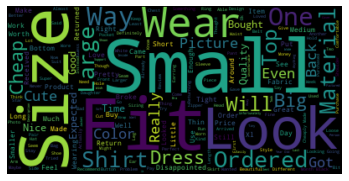

1.00 Fit
0.85 Size
0.80 Small
0.65 Look
0.53 Wear
0.46 One
0.44 Nice


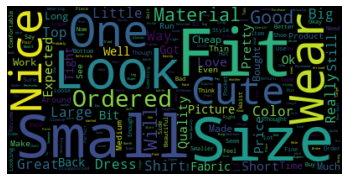

1.00 Fit
0.75 Size
0.58 Great
0.56 Love
0.50 Nice
0.48 Wear
0.46 Look


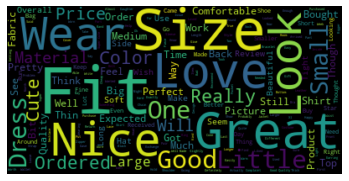

1.00 Love
0.60 Great
0.59 Fit
0.36 Wear
0.36 Size
0.33 Look
0.33 Nice


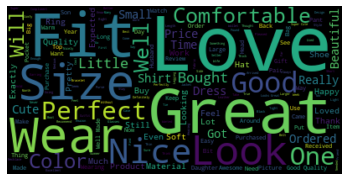

In [14]:
 for n in range(1,6):
    text = ' '.join(fashion[fashion["overall"]==n].sample(3000)["reviewText"].dropna().str.title().values)

    wc = WordCloud()
    wc.stopwords.add("i")
    wc.generate(text)

    for each_tuple in list(wc.words_.items())[0:7]:
        word, pct = each_tuple
        print("{:.2f}".format(pct), word)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Looking at the visualization, there seems to be clear similarities between 4-5 and 1-3 star review texts. We'll create that column now. We will code reviews as 1 for negativity if the score is 3 or less.

### 2.3.3 Create Target Feature as Boolean <a name="2.3.3"><a/>

In [15]:
fashion["negative"] = fashion["overall"].apply(lambda x: 1 if x <= 3 else 0)


In [16]:
fashion.head()

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negative
0,5,True,A1D4G1SNUZWQOT,7106116521,exactly what i needed.,perfect replacements!!,1413763200,0
1,2,True,A3DDWDH9PX2YX2,7106116521,"i agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,1
2,4,False,A2MWC41EW7XL15,7106116521,love these... i am going to order another pack...,My New 'Friends' !!,1408924800,0
3,2,True,A2UH2QQ275NV45,7106116521,too tiny an opening,Two Stars,1408838400,1
4,3,False,A89F3LQADZBS5,7106116521,okay,Three Stars,1406419200,1


1.00 Love
0.51 Wear
0.34 Bought
0.31 Ordered
0.30 Comfortable
0.29 Fit
0.29 Size


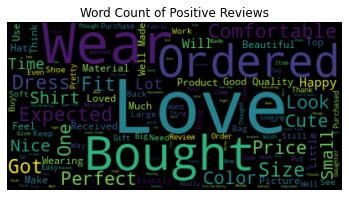

1.00 Small
0.71 Fit
0.57 Wear
0.56 Ordered
0.56 Look
0.52 Size
0.51 Way


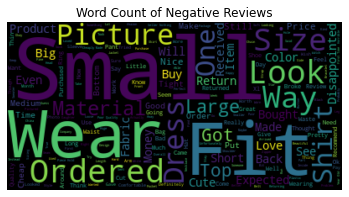

In [17]:
for n in range(0,2):
    text = ' '.join(fashion[fashion["negative"]==n]["reviewText"].str.title().values)

    wc = WordCloud()
    wc.stopwords.add("i")
    wc.generate(text)

    for each_tuple in list(wc.words_.items())[0:7]:
        word, pct = each_tuple
        print("{:.2f}".format(pct), word)
    
    
    
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    if n == 0:
        plt.title("Word Count of Positive Reviews")
    else:
        plt.title("Word Count of Negative Reviews")
    plt.show()

The word clouds now look pretty distinct which should hopefully mean our predictive models will work well.

### 2.3.4 Fix Contractions <a name="2.3.4"><a/>

Examine contractions in the dataset

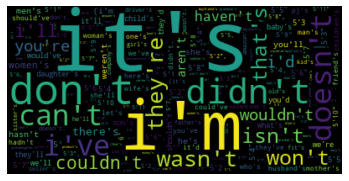

In [18]:
contraction_dict = {}

for sent in fashion["reviewText"]:
    for word in sent.split():
        if "'" in word:
            if contraction_dict.get(word):
                contraction_dict[word] += 1
            else:
                contraction_dict[word] = 1
                
wc = WordCloud()
wc.generate_from_frequencies(contraction_dict)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
df = pd.DataFrame([(k,v) for k,v in contraction_dict.items()], columns=["word", "count"])

In [20]:
df.sort_values("count", ascending=False, inplace=True)
df.head(20)

,word,count
6,it's,98811
17,i'm,62157
1,don't,43940
18,didn't,28558
5,doesn't,21345
10,i've,19334
26,can't,18839
27,wasn't,11092
0,they're,11032
8,won't,9449


In [21]:
replacement_dict = {"it's": "it is",
                   "i'm": "i am",
                   "don't": "do not",
                   "didn't": "did not",
                   "doesn't": "does not",
                   "i've": "i have",
                   "can't": "can not",
                   "wasn't": "was not",
                   "they're": "they are",
                   "won't": "will not",
                   "that's": "that is",
                   "isn't": "is not",
                   "couldn't": "could not",
                   "i'll": "i will",
                   "wouldn't": "would not",
                   "i'd": "i would",
                   "you're": "you are",
                   "haven't": "have not",
                   "aren't": "are not",
                   "there's": "there is"}

In [22]:
for k,v in replacement_dict.items():
    fashion["reviewText"] = fashion["reviewText"].str.replace(k, v)

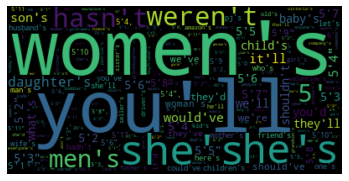

In [23]:
contraction_dict = {}

for sent in fashion["reviewText"]:
    for word in sent.split():
        if "'" in word:
            if contraction_dict.get(word):
                contraction_dict[word] += 1
            else:
                contraction_dict[word] = 1
                
wc = WordCloud()
wc.generate_from_frequencies(contraction_dict)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.3.5 Examine Review Lengths <a name="2.3.5"><a/>

In [24]:
fashion["review_length"] = fashion["reviewText"].apply(lambda x: len(x.split(' ')))

In [25]:
fashion["review_length"].describe()

count    874374.000000
mean         29.098817
std          39.360732
min           1.000000
25%           7.000000
50%          17.000000
75%          36.000000
max        2196.000000
Name: review_length, dtype: float64

In [26]:
fashion[fashion.review_length>=1000].head(10)

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negative,review_length
14525,4,True,A1DXBB13KCWHMV,B000KPIHQ4,i really wanted to write an in depth helpful r...,One of only 2 OTC inserts that have helped me.,1437177600,0,1001
23346,4,True,A3PMNUBMNX9P5J,B000PMKBL6,"as a woman, most of us have multiple pairs of ...",Great- depending on the type of boot.,1487548800,0,1165
24519,5,True,A36O3OTEKIX4U7,B000UJA696,i have had the m65 field jacket for about 5 we...,M65 Field Jacket with ALS liner,1422748800,0,1284
28028,4,True,A1DXBB13KCWHMV,B000V0IBDM,i really wanted to write an in depth helpful r...,One of only 2 OTC inserts that have helped me.,1437177600,0,1001
34025,5,True,A15NN5SM9DSONL,B0014JDIW8,(i purchased this under my wife's login.)\n\ni...,Something I'm happy to carry!,1375488000,0,1273
55649,5,False,A3VCTYH93B5E2V,B000UJDPHQ,i am a m-65 junkie / collector. i currently ow...,Alpha v. Propper v. Rothco,1241740800,0,1167
55863,5,True,A36O3OTEKIX4U7,B000UJDPHQ,i have had the m65 field jacket for about 5 we...,M65 Field Jacket with ALS liner,1422748800,0,1284
219191,4,True,A30JYY7WWK4MOU,B00NR1Y30C,just got my corset in the mail today! i have a...,great for the price range!,1432598400,0,1096
286754,5,True,A20UQDUH2J0B6W,B00ZOWJI7A,i received my amazon order for two of these ch...,Just what I need.,1493683200,0,1234
433455,4,False,AYRGN7W7BDD34,B0090US1WU,i bought this watch directly from sea-gull's u...,Excellent watch for the price - a couple of flaws,1352419200,0,1129


#### Examine longer reviews to see distribution of ratings

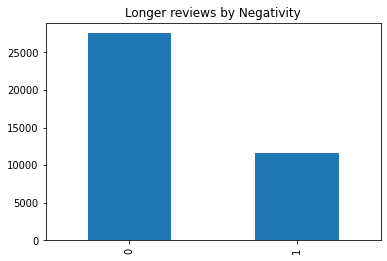

In [27]:
fashion[fashion["review_length"]>100]["negative"].value_counts().sort_index().plot.bar()
plt.title("Longer reviews by Negativity");

We see more long reviews are positive than negative with about 35,000 reviews over 1000 words long. This is pretty reflective of the distribution of positive/negative reviews in our data.

In [28]:
fashion["negative"].sum()/len(fashion["negative"])

0.30479405837776513

Roughly 30% of the total reviews are negative (1).

#### Examine Shorter reviews to see distribution of ratings

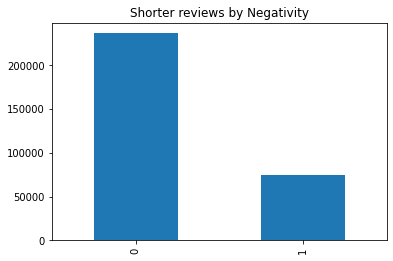

In [29]:
fashion[fashion["review_length"]<=10]["negative"].value_counts().sort_index().plot.bar()
plt.title("Shorter reviews by Negativity");

The difference seems slight, but perhaps there is a slightly higher proportion of short reviews which are positive (0).

Text(0.5, 1.0, 'Review Lengths: Heavy Right-Skewed Distribution')

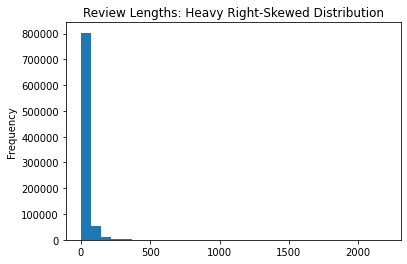

In [30]:
#Review lengths are heavily right-skewed - initial histogram plot is not informative

fashion.review_length.plot.hist(bins=30)
plt.title("Review Lengths: Heavy Right-Skewed Distribution")

In [31]:
fashion.review_length.describe()

count    874374.000000
mean         29.098817
std          39.360732
min           1.000000
25%           7.000000
50%          17.000000
75%          36.000000
max        2196.000000
Name: review_length, dtype: float64

In [32]:
fashion[fashion["review_length"] >= 1000]

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negative,review_length
14525,4,True,A1DXBB13KCWHMV,B000KPIHQ4,i really wanted to write an in depth helpful r...,One of only 2 OTC inserts that have helped me.,1437177600,0,1001
23346,4,True,A3PMNUBMNX9P5J,B000PMKBL6,"as a woman, most of us have multiple pairs of ...",Great- depending on the type of boot.,1487548800,0,1165
24519,5,True,A36O3OTEKIX4U7,B000UJA696,i have had the m65 field jacket for about 5 we...,M65 Field Jacket with ALS liner,1422748800,0,1284
28028,4,True,A1DXBB13KCWHMV,B000V0IBDM,i really wanted to write an in depth helpful r...,One of only 2 OTC inserts that have helped me.,1437177600,0,1001
34025,5,True,A15NN5SM9DSONL,B0014JDIW8,(i purchased this under my wife's login.)\n\ni...,Something I'm happy to carry!,1375488000,0,1273
55649,5,False,A3VCTYH93B5E2V,B000UJDPHQ,i am a m-65 junkie / collector. i currently ow...,Alpha v. Propper v. Rothco,1241740800,0,1167
55863,5,True,A36O3OTEKIX4U7,B000UJDPHQ,i have had the m65 field jacket for about 5 we...,M65 Field Jacket with ALS liner,1422748800,0,1284
219191,4,True,A30JYY7WWK4MOU,B00NR1Y30C,just got my corset in the mail today! i have a...,great for the price range!,1432598400,0,1096
286754,5,True,A20UQDUH2J0B6W,B00ZOWJI7A,i received my amazon order for two of these ch...,Just what I need.,1493683200,0,1234
433455,4,False,AYRGN7W7BDD34,B0090US1WU,i bought this watch directly from sea-gull's u...,Excellent watch for the price - a couple of flaws,1352419200,0,1129


We can see the majority of the longest reviews are glowingly positive.

The mean review length is just under 30 words long but we have a high standard deviation because of the relatively sparse, extremely long reviews.

High, sparse values are skewing our bins. Review length is strongly right-skewed. Most of our reviews are at the (relatively) low end of word count.

In [33]:
log_transformed_length = fashion["review_length"].apply(lambda x: np.log(x))

log_transformed_length.describe()


count    874374.000000
mean          2.727926
std           1.204597
min           0.000000
25%           1.945910
50%           2.833213
75%           3.583519
max           7.694393
Name: review_length, dtype: float64

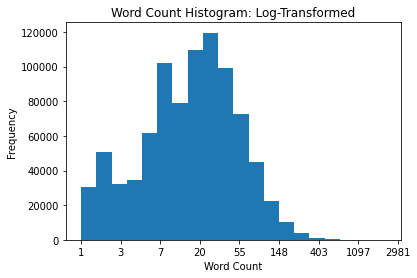

In [34]:
log_transformed_length.plot.hist(bins=20)
plt.title("Word Count Histogram: Log-Transformed")
plt.xticks(range(9), labels=[round(e**x) for x in range(9)]) #set actual word counts for x-axis labels
plt.xlabel("Word Count");

We see the bulk of reviews are between 5-100 words but there are also far more reviews under 5 words than over 150 words.

## 2.4 Text Cleaning <a name="2.4"><a/>

### 2.4.1  Removing numbers and punctuation <a name="2.4.1"></a>

A regex is a quick way to clean a series of the string type with Pandas vectorized operations.



Note: We ARE removing numbers as well as punctuation. This is a conscious choice. In our case, the number 1 or 5 might be predictive for a model, but not applicable in other settings such as a tweet about a product. We are sacrificing a bit of predictive power for a model which should generalize better to other data.

In [35]:
import re
pattern = re.compile(r"[^A-Za-z ]+")

Quickly test the regex.

In [36]:
pd.Series(["Wh375at*&", "the#*234@#$", r"%$heck(*&(*&#$||))"]).str.replace(pattern, " ", regex=True)

0    Wh at 
1      the 
2     heck 
dtype: object

In [37]:
fashion["reviewText"] = fashion.reviewText.str.replace(pattern, " ", regex=True)

In [38]:
for char in list("!@#%^&*(){}|_+="):
    if fashion.reviewText.str.contains(char, regex=False).sum() == 0:
        print(f"{char} not found in review text.")

! not found in review text.
@ not found in review text.
# not found in review text.
% not found in review text.
^ not found in review text.
& not found in review text.
* not found in review text.
( not found in review text.
) not found in review text.
{ not found in review text.
} not found in review text.
| not found in review text.
_ not found in review text.
+ not found in review text.
= not found in review text.


In [39]:
fashion.reviewText.str.contains("  ").sum()

619358

There are multiple spaces between words now due to replacing punctuation. We'll change these to single spaces.

In [40]:
fashion["reviewText"] = fashion.reviewText.str.replace(" +", " ", regex=True)

In [41]:
fashion.reviewText.str.contains("  ").sum()

0

### 2.4.2 Removing stop words <a name="2.4.2"><a/>

Stop words which don't have significant meaning for the text will give us noisy data and worse predictions. There is some debate over whether removing them will give better results. For simplicity's sake we will remove them.

In [42]:
#Let's remove "not" which may indicate dissatisfaction
STOP_WORDS.remove("not")


Customize the stop words since we removed punctuation already.

In [43]:
stops = []
for i, word in enumerate(STOP_WORDS):
    stops.append(word.strip())
    stops.append(word.replace("'", ""))
    
stops = set(stops)

In [44]:
fashion["reviewText"] = fashion["reviewText"].apply(lambda x: ' '.join([w.strip() if not w.strip() in stops else '' for w in x.split()]))

In [45]:
fashion.head()

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negative,review_length
0,5,True,A1D4G1SNUZWQOT,7106116521,exactly needed,perfect replacements!!,1413763200,0,4
1,2,True,A3DDWDH9PX2YX2,7106116521,agree review opening small bent hook...,"I agree with the other review, the opening is ...",1411862400,1,49
2,4,False,A2MWC41EW7XL15,7106116521,love going order pack work including ...,My New 'Friends' !!,1408924800,0,50
3,2,True,A2UH2QQ275NV45,7106116521,tiny opening,Two Stars,1408838400,1,4
4,3,False,A89F3LQADZBS5,7106116521,okay,Three Stars,1406419200,1,1


In [46]:
fashion.reviewText.str.contains("  ").sum()

757176

There are multiple spaces between words again due to replacing stop words. We'll change these to single spaces.

In [47]:
fashion["reviewText"] = fashion.reviewText.str.replace(" +", " ", regex=True)

In [48]:
fashion.reviewText.str.contains("  ").sum()

0

Let's check if we have any empty reviews after remove punctuation and stop words.

In [49]:
fashion[fashion.reviewText == '']

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negative,review_length
386,5,True,A2AFZG45B85CT1,B00062NHH0,,Five Stars,1440201600,0,1
427,5,True,A11DNVHRYUDZA3,B00062NHH0,,Five Stars,1429747200,0,1
655,5,True,A1QUQ5UQYKD7B8,B00062NHH0,,Five Stars,1412035200,0,1
1068,5,True,A3ACF936MR45AZ,B00066G516,,:),1463616000,0,1
2509,2,True,A3QLYE978DLSHS,B000AL4RXA,,None,1420329600,1,1
...,...,...,...,...,...,...,...,...,...
877466,5,True,A3V8Q7940J8W4Q,B01H4CUJ98,,Five Stars,1506384000,0,1
877997,5,True,A273HA2ZNZVXOR,B01H51FWQS,,LOVE IT!!,1494979200,0,1
878405,5,True,A1VX138OIOR5TV,B01H5TCN4E,,Five Stars,1515801600,0,1
880444,5,True,A3IN8QA6VV1BDS,B01HBY1NS0,,Five Stars,1484179200,0,1


Let's drop those.

In [50]:
fashion = fashion[~(fashion.reviewText == '')]

In [51]:
fashion[fashion.reviewText == '']

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negative,review_length


In [52]:
cleaned_data = fashion[["reviewText", "negative", "overall", "review_length"]]

In [53]:
rows_after = cleaned_data.shape[0]

print("At the start of the notebook we had {} rows, at the end {} rows".format(rows_before, rows_after))

At the start of the notebook we had 883636 rows, at the end 873352 rows


After cleaning the data and dropping null or missing reviews, we ended with about 10,000 fewer rows.

In [54]:
cleaned_data.columns = ["review", "neg_sentiment", "stars", "review_length"]

In [55]:
cleaned_data.head()

,review,neg_sentiment,stars,review_length
0,exactly needed,0,5,4
1,agree review opening small bent hook expensiv...,1,2,49
2,love going order pack work including losing ea...,0,4,50
3,tiny opening,1,2,4
4,okay,1,3,1


## 2.5 Save the data <a name="2.5"><a/>

In [56]:
cleaned_data.to_parquet("../data/edited/fashion.parquet")

## 2.6 Conclusions <a name="2.6"><a/>

### 2.6.1 Summary <a name="2.6.1"><a/>

1. Review text data has been cleaned. Stop words and puncuation were removed. There could still be mis-spelled words in the data or words that do not exist, with a very low frequency.

2. Reviews with 4 and 5 stars have been coded as 0 (positive reviews). Reviews with 1-3 stars have been coded as 1 (negative reviews). As most reviews are positive (60-80 percent of our dataset), we are more interested in predicting the negative reviews from a business standpoint as those products may have serious problems which will hurt the bottom line.

3. The majority of reviews are roughly between 5 words and 100 words in length. Examining how our model performs on the shortest/longest reviews should be something to keep in mind.

### 2.6.2 Next steps <a name="2.6.2"><a/>

1. The data does not have an even split (roughly 70/30). This may have an effect on future modeling/prediction accuracy which we will have to keep in mind.

2. The words in the document should be either stemmed or lemmatized. Ie. (kicked -> kick, seeing -> see)

3. The data must be converted from text to numeric features for essentially all ML models. There are a few different options for doing this including simple word counts (count vectorization), scaled word counts (Term Frequency, Inverse Document Frequency), and word2vec (context sensitive numeric encoding).

4. Split the data into train-test sets and build a simple, initial predictive model.